In [38]:
%matplotlib inline
import os

from pprint import pprint
import numpy as np
import pandas as pd
from planet import api
import matplotlib.pyplot as plt

In [23]:
client = api.Client()

In [24]:
mosaics = client.list_mosaics().get()

In [25]:
[m['name'] for m in mosaics['mosaics']]

[u'landsat8_toa_rgb_mosaic',
 u'open_california_planetscope_mosaic',
 u're_california_summer_mosaic',
 u'open_california_hybrid_mosaic',
 u'open_california_re_20130901_20131130',
 u'open_california_re_20131201_20140228',
 u'open_california_re_20140101_20141231',
 u'open_california_re_20140301_20140531',
 u'open_california_re_20140601_20140831',
 u'open_california_re_20140901_20141130',
 u'open_california_re_20141201_20150228',
 u'open_california_re_20150101_20151231',
 u'open_california_re_20150301_20150531',
 u'open_california_re_20150601_20150831']

In [26]:
mosaic = client.get_mosaic('open_california_re_20150601_20150831')
mosaic.get()

{u'coordinate_system': u'EPSG:3857',
 u'datatype': u'uint16',
 u'first_acquired': u'2015-06-11T00:00:00+00:00',
 u'geometry': {u'coordinates': [[[-124.551309208076, 32.3817750302967],
    [-124.551309208076, 42.1341418694333],
    [-113.945370784834, 42.1341418694333],
    [-113.945370784834, 32.3817750302967],
    [-124.551309208076, 32.3817750302967]]],
  u'type': u'Polygon'},
 u'last_acquired': u'2015-08-31T23:59:59.999999+00:00',
 u'level': 15,
 u'links': {u'quadmap': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quad-map.png',
  u'quads': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quads/',
  u'self': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831',
  u'tiles': u'https://tiles{0-3}.planet.com/v0/mosaics/open_california_re_20150601_20150831/{z}/{x}/{y}.png'},
 u'name': u'open_california_re_20150601_20150831',
 u'quad_pattern': u'L{glevel:d}-{tilex:04d}E-{tiley:04d}N',
 u'quad_size': 4096,
 u'resolutio

In [27]:
location = {"type":"Point","coordinates":[-123.79394531249999,39.291797043774864]}
client.get_mosaic_quads('open_california_re_20150601_20150831',
                        intersects=location).get()

{u'features': [{u'geometry': {u'coordinates': [[[-123.925781233,
       39.3682791446],
      [-123.925781233, 39.2322531372],
      [-123.749999983, 39.2322531372],
      [-123.749999983, 39.3682791446],
      [-123.925781233, 39.3682791446]]],
    u'type': u'Polygon'},
   u'id': u'L15-0319E-1267N',
   u'properties': {u'links': {u'full': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quads/L15-0319E-1267N/full',
     u'mosaic': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831',
     u'scenes': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quads/L15-0319E-1267N/scenes/',
     u'self': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quads/L15-0319E-1267N',
     u'thumbnail': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quads/L15-0319E-1267N/thumb'},
    u'num_input_scenes': 6,
    u'percent_covered': 100.0,
    u'updated': u'2016-03-04T04:07:48.539853+00:00'}

In [41]:
points = np.load('/Users/ajmendez/tmp/world/coast_points.np.npy')
downloaded = []

In [46]:
mosaic_name = 'open_california_re_20150601_20150831'

outdir = '/Users/ajmendez/tmp/world/planet/{}'.format(mosaic_name)
if not os.path.exists(outdir):
    os.makedirs(outdir)
callback = api.write_to_file(outdir)

for point in points:
    location = {"type":"Point","coordinates":list(point)}
    quad = client.get_mosaic_quads(mosaic_name, intersects=location).get()
    for q in quad['features']:
        qid = q['id']
        if qid in downloaded:
            continue
        downloaded.append(qid)
        bodies = client.fetch_mosaic_quad_geotiffs(mosaic_name, [qid], callback=callback)
        for i,b in enumerate(bodies):
            b.await()
            print i, qid
    break

In [ ]:
p

In [70]:
outlines = {}
for i,point in enumerate(points):
    location = {"type":"Point","coordinates":list(point)}
    quad = client.get_mosaic_quads(mosaic_name, intersects=location).get()
    for q in quad['features']:
        qid = q['id']
        if qid in outlines:
            continue
        
        outlines[qid] = (q['geometry']['coordinates'][0])
    break
#     if len(outlines) > 2:
#         break

In [91]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]
# for i, chunk in enumerate(chunks(points, 600)):
#     print i, len(chunk)

0 600
1 600
2 600
3 600
4 600
5 600
6 600
7 600
8 600
9 600
10 600
11 600
12 600
13 600
14 600
15 600
16 600
17 600
18 600
19 600
20 600
21 600
22 600
23 600
24 600
25 600
26 600
27 600
28 600
29 600
30 600
31 600
32 600
33 600
34 600
35 600
36 600
37 600
38 600
39 600
40 600
41 600
42 600
43 600
44 600
45 600
46 600
47 600
48 600
49 600
50 600
51 600
52 600
53 600
54 600
55 600
56 600
57 600
58 600
59 600
60 600
61 600
62 600
63 600
64 600
65 600
66 600
67 600
68 600
69 600
70 600
71 600
72 600
73 600
74 600
75 600
76 600
77 600
78 600
79 600
80 600
81 600
82 600
83 600
84 600
85 600
86 600
87 600
88 600
89 600
90 600
91 600
92 600
93 600
94 600
95 600
96 600
97 600
98 600
99 600
100 600
101 600
102 600
103 600
104 600
105 600
106 600
107 600
108 600
109 600
110 600
111 600
112 600
113 600
114 600
115 600
116 600
117 600
118 600
119 600
120 600
121 600
122 600
123 600
124 600
125 600
126 600
127 600
128 600
129 600
130 600
131 600
132 600
133 600
134 600
135 600
136 600
137 600
138 60

In [98]:
for i, chunk in enumerate(chunks(points[::-1], 100)):
    location = {"type":"LineString","coordinates":[list(p) for p in chunk]}
    quads = client.get_mosaic_quads(mosaic_name, intersects=location).get()
    for q in quads['features']:
        qid = q['id']
        if qid in outlines:
            continue
        outlines[qid] = (q['geometry']['coordinates'][0])

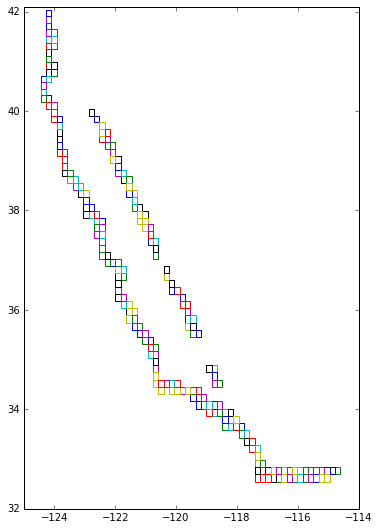

In [99]:
plt.figure(figsize=(6,9))
plt.xlim(-125, -114)
plt.ylim(32, 42.1)
for key, outline in outlines.iteritems():
    x,y = zip(*outline)
    plt.plot(x,y)

In [ ]:
for i, oids in enumerate(chunks(outlines.keys(), 10)):
    quads = client.fetch_mosaic_quad_geotiffs(mosaic_name, oids, callback=callback)
    quads = client.
    for q in quads:
        q.await()

In [102]:
outlines

{u'L15-0316E-1274N': [[-124.453124983, 40.3130432043],
  [-124.453124983, 40.1788733097],
  [-124.277343733, 40.1788733097],
  [-124.277343733, 40.3130432043],
  [-124.453124983, 40.3130432043]],
 u'L15-0316E-1275N': [[-124.453124983, 40.446947055],
  [-124.453124983, 40.3130432043],
  [-124.277343733, 40.3130432043],
  [-124.277343733, 40.446947055],
  [-124.453124983, 40.446947055]],
 u'L15-0316E-1276N': [[-124.453124983, 40.5805846595],
  [-124.453124983, 40.446947055],
  [-124.277343733, 40.446947055],
  [-124.277343733, 40.5805846595],
  [-124.453124983, 40.5805846595]],
 u'L15-0316E-1277N': [[-124.453124983, 40.7139558216],
  [-124.453124983, 40.5805846595],
  [-124.277343733, 40.5805846595],
  [-124.277343733, 40.7139558216],
  [-124.453124983, 40.7139558216]],
 u'L15-0317E-1273N': [[-124.277343733, 40.1788733097],
  [-124.277343733, 40.04443758],
  [-124.101562483, 40.04443758],
  [-124.101562483, 40.1788733097],
  [-124.277343733, 40.1788733097]],
 u'L15-0317E-1274N': [[-124.2

In [ ]:
s